<h1>Import libraries</h1>

In [1]:
import pandas as pd
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

<h1>Declare global variables</h1>

In [2]:
MAX_FEATURES = 58439  # size of word index, set to the number of unique words in dataset
EMBEDDING_DIM = 200
MAX_LEN = 30  # average size of twitter text as used in the paper

<h1>Read csv</h1>

In [3]:
df = pd.read_csv('tweets.csv')
df

,Tweet text,Label,Votes for the majority label
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,spam,4
1,RT @Papapishu: Man it would fucking rule if we...,abusive,4
2,It is time to draw close to Him &#128591;&#127...,normal,4
3,if you notice me start to act different or dis...,normal,5
4,"Forget unfollowers, I believe in growing. 7 ne...",normal,3
...,...,...,...
99991,RT @shangros: my fucking queen https://t.co/wa...,abusive,5
99992,#Osteporosis treated with #PEMF - rebuild bone...,normal,3
99993,@LGUSAMobile why does my phone screen keeps fl...,normal,3
99994,#bigdata vs. #reality ... but equally applies ...,normal,5


<h1>Drop spam labeled tweets and reset index</h1>

In [4]:
df = df[df['Label'] != "spam"].dropna()
df = df.reset_index(drop=True)
df

,Tweet text,Label,Votes for the majority label
0,RT @Papapishu: Man it would fucking rule if we...,abusive,4
1,It is time to draw close to Him &#128591;&#127...,normal,4
2,if you notice me start to act different or dis...,normal,5
3,"Forget unfollowers, I believe in growing. 7 ne...",normal,3
4,RT @Vitiligoprince: Hate Being sexually Frustr...,abusive,4
...,...,...,...
85961,RT @shangros: my fucking queen https://t.co/wa...,abusive,5
85962,#Osteporosis treated with #PEMF - rebuild bone...,normal,3
85963,@LGUSAMobile why does my phone screen keeps fl...,normal,3
85964,#bigdata vs. #reality ... but equally applies ...,normal,5


<h1>Combining abusive and hateful tweets to one labeled, named harmful</h1>

In [5]:
df['Label'] = df['Label'].replace(['abusive', 'hateful'], 'harmful')
df

,Tweet text,Label,Votes for the majority label
0,RT @Papapishu: Man it would fucking rule if we...,harmful,4
1,It is time to draw close to Him &#128591;&#127...,normal,4
2,if you notice me start to act different or dis...,normal,5
3,"Forget unfollowers, I believe in growing. 7 ne...",normal,3
4,RT @Vitiligoprince: Hate Being sexually Frustr...,harmful,4
...,...,...,...
85961,RT @shangros: my fucking queen https://t.co/wa...,harmful,5
85962,#Osteporosis treated with #PEMF - rebuild bone...,normal,3
85963,@LGUSAMobile why does my phone screen keeps fl...,normal,3
85964,#bigdata vs. #reality ... but equally applies ...,normal,5


<h1>Map harmful to 0 and normal to 1</h1>

In [6]:
df['Label'] = df['Label'].replace(["harmful", "normal"], [0, 1])
df

,Tweet text,Label,Votes for the majority label
0,RT @Papapishu: Man it would fucking rule if we...,0,4
1,It is time to draw close to Him &#128591;&#127...,1,4
2,if you notice me start to act different or dis...,1,5
3,"Forget unfollowers, I believe in growing. 7 ne...",1,3
4,RT @Vitiligoprince: Hate Being sexually Frustr...,0,4
...,...,...,...
85961,RT @shangros: my fucking queen https://t.co/wa...,0,5
85962,#Osteporosis treated with #PEMF - rebuild bone...,1,3
85963,@LGUSAMobile why does my phone screen keeps fl...,1,3
85964,#bigdata vs. #reality ... but equally applies ...,1,5


<h1>Declare the preprocessing function</h1>
<p>This function takes a string and applies several regular expressions on the string, in order to eliminate unecessary words.</p>

In [7]:
def preprocessing(text):
    # Different regex parts for smiley faces
    eyes = "[8:=;]"
    nose = "['`\-]?"

    text = re.sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<URL>", text)
    text = re.sub(r"/"," / ", text)
    text = re.sub(r"@\w+", "<USER>", text)
    text = re.sub(rf"{eyes}{nose}\)+|\(+{nose}{eyes}", "<SMILE>", text)
    text = re.sub(rf"{eyes}{nose}p+", "<LOLFACE>", text)
    text = re.sub(rf"{eyes}{nose}\(+|\)+{nose}{eyes}", "<SADFACE>", text)
    text = re.sub(rf"{eyes}{nose}[/|l]+", "<NEUTRALFACE>", text)
    text = re.sub(r"<3", "<HEART>", text)
    text = re.sub(r"[\-\+]?[.\d]*[\d]+[:,.\d]*", "<NUMBER>", text)
    text = re.sub(r"#", "<HASHTAG>", text)
    text = re.sub(r"([!?.]){2,}", r"\1 <REPEAT>", text)
    text = re.sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <ELONG>", text)
    
    return text

<h1>Retrieve tweets text and apply the preprocessing function</h1>

In [8]:
text = df['Tweet text'].tolist()
for i, j in zip(text, range(len(text))):
    text[j] = preprocessing(i)

<h1>Load glove model function</h1>
<p>Create the glove model from every word in the text file we downloaded</p>

In [9]:
def loadGloveModel():
    print("Loading Glove Model")
    with open("glove.twitter.27B.200d.txt", 'r', encoding='utf8') as f:
        gloveModel = {}
        for line in f:
            splitLines = line.split()
            word = splitLines[0]
            wordEmbedding = np.array([float(value) for value in splitLines[1:]])
            gloveModel[word] = wordEmbedding
        f.close()
    print(len(gloveModel), " words loaded!")
    return gloveModel

<h1>Convert words of tweets to vectors using the gloVe model</h1>

In [10]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
# create a word index vocabulary for each word in the dataset

tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index

# load pretrained Embedding
gloveModel = loadGloveModel()

text_embedding = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
found = 0
not_found = 0
# embedding_matrix = np.zeros((len(word_index) + 1, 25))
for word, i in word_index.items():
    if i >= (len(word_index) + 1):
        continue
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        text_embedding[i] = embedding_vector
        found += 1
    else:
        not_found += 1


print("Found: ", found, " Not found: ", not_found)

list_tokenized_train = tokenizer.texts_to_sequences(text)
x = pad_sequences(list_tokenized_train, maxlen=MAX_LEN, padding="post")
y = df['Label'].tolist()

Loading Glove Model
1193514  words loaded!
Found:  47673  Not found:  28396


<h1>Create the kmeans model</h1>

In [11]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(x)
labels = kmeans.labels_

<h1>Create a new dataframe with the original text, original label and output of kmeans</h1>

In [12]:
new_df = pd.DataFrame({'Original Text':df['Tweet text'], 
                       'Original Label':df['Label'], 
                       'Label':labels})
new_df

,Original Text,Original Label,Label
0,RT @Papapishu: Man it would fucking rule if we...,0,1
1,It is time to draw close to Him &#128591;&#127...,1,1
2,if you notice me start to act different or dis...,1,1
3,"Forget unfollowers, I believe in growing. 7 ne...",1,1
4,RT @Vitiligoprince: Hate Being sexually Frustr...,0,1
...,...,...,...
85961,RT @shangros: my fucking queen https://t.co/wa...,0,1
85962,#Osteporosis treated with #PEMF - rebuild bone...,1,1
85963,@LGUSAMobile why does my phone screen keeps fl...,1,1
85964,#bigdata vs. #reality ... but equally applies ...,1,1


<h1>Print info on normal labeled data</h1>

In [13]:
normal_df = new_df[new_df["Original Label"] == 1]
normal_df['Label'].value_counts()

1    40932
0    12919
Name: Label, dtype: int64

<h1>Print info on harmful labeled data</h1>

In [14]:
harmful_df = new_df[new_df["Original Label"] == 0]
harmful_df['Label'].value_counts()

1    29569
0     2546
Name: Label, dtype: int64

<h1>Create a results dataframe</h1>

In [15]:
results = pd.DataFrame({'Normal':normal_df['Label'].value_counts(),
                        'Harmful':harmful_df['Label'].value_counts()})
results

,Normal,Harmful
1,40932,29569
0,12919,2546


<h1>Bar plot of results</h1>

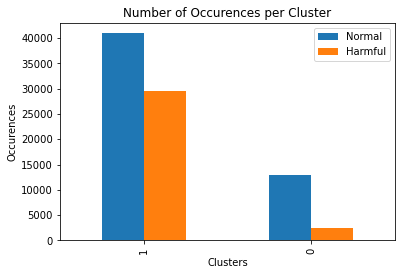

In [16]:
results.plot.bar()
plt.xlabel("Clusters")
plt.ylabel("Occurences")
plt.title("Number of Occurences per Cluster")
plt.show()

<h1>Print the accuracy of each cluster</h1>

In [17]:
print("Individual dataset accuracy:")
print(" For normal labeled data  = ", results["Normal"][1]/(results["Normal"].sum()))
print(" For harmful labeled data = ", results["Harmful"][0]/(results["Harmful"].sum()))

Individual dataset accuracy:
 For normal labeled data  =  0.7600973055282167
 For harmful labeled data =  0.07927759613887592


<h1>Print the overall model accuracy</h1>

In [18]:
score = accuracy_score(new_df['Original Label'], new_df['Label'])
print('Overall accuracy = %.3f' % (score*100))

Overall accuracy = 50.576
